# Introduction

<a href="https://colab.research.google.com/github/riccardoberta/machine-learning/blob/master/01_introduction/introduction.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Google Colab"/></a>


## Example 

We will start with an example. It is from the paper [A. Siaroh et al. **First Order Motion Model for Image Animation** Advances in Neural Information Processing Systems NIPS 2019](https://arxiv.org/abs/2003.00196) and it is an application of machine learning to **image animation**, which consists of generating a video sequence so that an object in a source image is animated according to the motion of a driving video. Once trained on a set of videos depicting objects of the same category (e.g. faces, human bodies), this method can be applied to any object of the same class.

You need to install ffmpeg and torch libraries.  

### Load data

In [13]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

Load an a source image and a driving video.

In [14]:
source_image = imageio.imread('./data/may.png')
reader = imageio.get_reader('./data/obama.mp4')

Resize the source image 256x256

In [15]:
source_image = resize(source_image, (256, 256))[..., :3]

Resize the driving video to 256x256

In [16]:
fps = reader.get_meta_data()['fps']
driving_video = []
try:
    for im in reader:
        driving_video.append(im)
except RuntimeError:
    pass
reader.close()
driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]

Show the source image and the driving video

In [17]:
def display(source, video, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))
    ims = []
    for i in range(len(video)):
        cols = [source]
        cols.append(video[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani

HTML(display(source_image, driving_video).to_html5_video())

### Apply a Machine Learning model

Load a model from a checkpoin

In [20]:
from deepfake import load_checkpoints
generator, kp_detector = load_checkpoints(config_path='./config/vox-256.yaml', 
                                          checkpoint_path='./data/vox-cpk.pth.tar', cpu=True)

Perform image animation

In [22]:
from deepfake import make_animation
from skimage import img_as_ubyte

predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=True, cpu=True)

imageio.mimsave('./data/mayobama.mp4', [img_as_ubyte(frame) for frame in predictions], fps=fps)

HTML(display(source_image, driving_video, predictions).to_html5_video())

100%|██████████| 265/265 [05:55<00:00,  1.34s/it]


[TBD]

## Supervised, Unsupervised and Reinforcment Learning

<table border="1">
<tr>
    <td> <b>Question</b> </td>
    <td style="border-left: 1px solid black"> <b>Supervised</b> </td>
    <td style="border-left: 1px solid black"> <b>Unsupervised</b> </td>
    <td style="border-left: 1px solid black"> <b>Reinforcement</b> </td>
</tr>
<tr>
    <td> Target </td>
    <td style="border-left: 1px solid black"> $f(x)=y$ </td>
    <td style="border-left: 1px solid black"> $x\in X$ </td>
    <td style="border-left: 1px solid black"> $\pi(s)=a$ </td>
</tr>
<tr>
    <td> Target (rephrased) </td>
    <td style="border-left: 1px solid black"> Predict outputs given inputs</td>
    <td style="border-left: 1px solid black"> Discover structure in data </td>
    <td style="border-left: 1px solid black"> Find an optimal behavior </td>
</tr>
<tr>
    <td> Data </td>
    <td style="border-left: 1px solid black"> $\left\{\left(x,y\right)\right\}$ supervisor's labels </td>
    <td style="border-left: 1px solid black"> $\left\{x\right\}$ unlabelled data </td>
    <td style="border-left: 1px solid black"> $\left\{\left(s,a,r,s'\right)\right\}$ experience samples </td>
</tr>
<tr>
    <td> Output </td>
    <td style="border-left: 1px solid black"> Classifier or regressor</td>
    <td style="border-left: 1px solid black"> Clusters or dimension reduction </td>
    <td style="border-left: 1px solid black"> Policies, value functions </td>
</tr>
<tr>
    <td> Key algorithms </td>
    <td style="border-left: 1px solid black"> Neural networks, SVMs, etc.</td>
    <td style="border-left: 1px solid black"> k-means, PCA, etc. </td>
    <td style="border-left: 1px solid black"> Q-learning, Policy Gradients, etc. </td>
</tr>
</table>

## Model and instance based learning

One way to categorize ML systems is by how they **generalize**. There are two main approaches to generalization: instance-based learning and model-based learning.
The most trivial form of learning is simply to learn by heart, then generalizes to new cases using a similarity measure. This is called **instance-based learning**.
Another way to generalize from a set of examples is to build a model of these examples, then use that model to make predictions. This is called **model-based learning**.

1. [Model based](#Model-based)
2. [Instance based](#Instance-based) 

For example, suppose you want to know if money makes people happy, so you download the Better Life Index data from the OECD’s website (bli) as well as stats about GDP per capita from the IMF’s website (gdp). Then you join the tables and sort by GDP per capita.

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model
import sklearn.neighbors

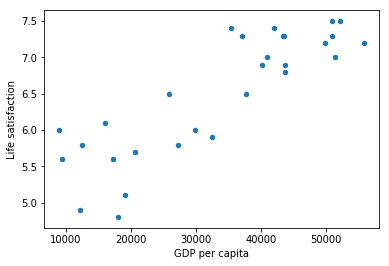

In [19]:
def prepare_stats(bli, gdp):
    bli = bli[bli["INEQUALITY"]=="TOT"]
    bli = bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp.set_index("Country", inplace=True)
    stats = pd.merge(left=bli, right=gdp, left_index=True, right_index=True)
    stats.sort_values(by="GDP per capita", inplace=True)
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    keep_indices = list(set(range(36)) - set(remove_indices))
    return stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]

# Load the data
bli = pd.read_csv("bli.csv", thousands=',')
gdp = pd.read_csv("gdp.csv", thousands=',', delimiter='\t', encoding='latin1', na_values="n/a")

# Prepare the data
stats = prepare_stats(bli, gdp)
X = np.c_[stats["GDP per capita"]]
y = np.c_[stats["Life satisfaction"]]

# Visualize the data
stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.show()

## Model based

There does seem to be a trend here! Although the data is noisy (i.e., partly random), it looks like life satisfaction goes up more or less linearly as the country’s GDP per capita increases. So you decide to model life satisfaction as a linear function of GDP per capita. This step is called **model selection**: you selected a linear model of life satisfaction with just one attribute, GDP per capita.
Before you can use your model, you need to define the parameter of the line. How can you know which values will make your model perform best? To answer this question, you need to specify a **performance measure**. You can either define a utility function (or fitness function) that measures how good your model is, or you can define a cost function that measures how bad it is. For linear regression problems, people typically use a cost function that measures the distance between the linear model’s predictions and the training examples; the objective is to minimize this distance.
This is where the Linear Regression algorithm comes in: you feed it your training examples and it finds the parameters that make the linear model fit best to your data. This is called **training the model**.

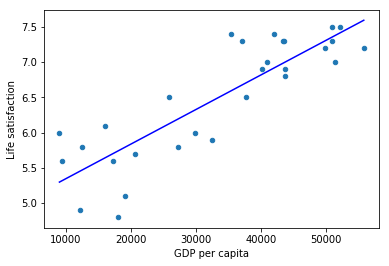

In [20]:
# Select a linear model
model = sklearn.linear_model.LinearRegression()

# Train the model
model.fit(X, y)

# Visualize model and data
stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.plot(X, model.intercept_[0] + model.coef_[0][0]*X, "b")
plt.show()

You are finally ready to run the model to make predictions. For example, say you want to know how happy Cypriots are, and the OECD data does not have the answer. Fortunately, you can use your model to make a good prediction: you look up Cyprus’s
GDP per capita, find $22,587, and then apply your model and find that life satisfaction.

In [21]:
# Make a prediction for Cyprus
X_cyprus = [[22587]]
y_cyprus = model.predict(X_cyprus)
print(y_cyprus) 

[[5.96242338]]


## Instance based

If you had used an instance-based learning algorithm instead, you can search out a bit arounf Cyprus GDP and look at the closest countries (you will find Slovenia, Portugal and Spain). Averaging these three values, you get 5.77, which is pretty close to the model-based prediction.
This simple algorithm is called **k-Nearest Neighbors (KNN)** regression (in this example, k = 3).

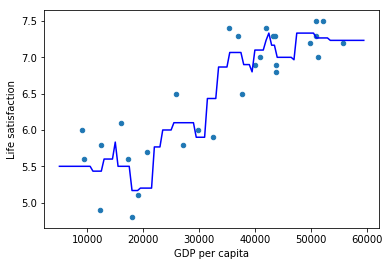

[[5.76666667]]


In [24]:
# Select KNN
model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=3)

# Train the model
model.fit(X, y)

# Visualize model and data
stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
values = np.c_[np.arange(5000, 60000, 500)]
predictions = model.predict(values)
plt.plot(values, predictions, "b")
plt.show()

# Make a prediction for Cyprus
X_new = [[22587]]  # Cyprus' GDP per capita
print(model.predict(X_new)) # outputs [[ 5.96242338]]